In [20]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#static num classes - we know its 10
batch_size = 128
num_classes = 10

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [23]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes, img_channels):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.noise_dim = noise_dim
        self.img_channels = img_channels

        self.gen = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Linear(2048, img_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_emb(labels)
        noise = noise.view(-1, self.noise_dim)
        x = torch.cat([noise, c], dim=1)
        output = self.gen(x)
        output = output.view(-1, self.img_channels, 64, 64)
        return output



class Discriminator(nn.Module):
    def __init__(self, img_channels, num_classes):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_channels * 64 * 64, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2)
        )

        self.src = nn.Linear(128, 1) 
        self.cls = nn.Linear(128, num_classes) 

    def forward(self, img):
        x = img.view(-1, 3 * 64 * 64)
        x = self.disc(x)
        src = torch.sigmoid(self.src(x))
        cls = self.cls(x)
        return src, cls

In [24]:
# initialize loss
adversarial_loss = nn.BCELoss()
classification_loss = nn.CrossEntropyLoss()

# hyperparameters
noise_dim = 100  
num_classes = 10 
img_channels = 3 

# model initialization
generator = Generator(noise_dim, num_classes, img_channels)
discriminator = Discriminator(img_channels, num_classes)

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    classification_loss.cuda()

# optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [6]:
#num epochs, from the paper
num_epochs = 50
g_losses = []
d_losses = []

fixed_noise = torch.randn(10, noise_dim).cuda()
fixed_labels = torch.LongTensor([i for i in range(10)]).cuda()

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)
        valid = torch.ones(batch_size, 1, device=device, requires_grad=False)
        fake = torch.zeros(batch_size, 1, device=device, requires_grad=False)

        real_imgs = imgs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.LongTensor).to(device)

        # Train generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, noise_dim, device=device)
        gen_labels = torch.LongTensor(np.random.randint(0, num_classes, batch_size)).to(device)

        # Generated images
        gen_imgs = generator(z, gen_labels)
        validity, pred_label = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid) + classification_loss(pred_label, gen_labels)
        g_loss.backward()
        optimizer_G.step()
        g_losses.append(g_loss.item())

        # Train discriminator
        optimizer_D.zero_grad()
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + classification_loss(real_aux, labels)) / 2

        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + classification_loss(fake_aux, gen_labels)) / 2

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        d_losses.append(d_loss.item())

    print(f"[Epoch {epoch}/{num_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

[Epoch 0/50] [D loss: 0.815453052520752] [G loss: 2.604973554611206]
[Epoch 1/50] [D loss: 0.7032866477966309] [G loss: 3.5426132678985596]
[Epoch 2/50] [D loss: 0.7021883130073547] [G loss: 3.4013941287994385]
[Epoch 3/50] [D loss: 1.0757784843444824] [G loss: 4.307231426239014]
[Epoch 4/50] [D loss: 0.6195530295372009] [G loss: 3.1771605014801025]
[Epoch 5/50] [D loss: 0.6270061731338501] [G loss: 2.3185997009277344]
[Epoch 6/50] [D loss: 0.6770942807197571] [G loss: 3.577132225036621]
[Epoch 7/50] [D loss: 0.76097172498703] [G loss: 3.4187533855438232]
[Epoch 8/50] [D loss: 0.7497682571411133] [G loss: 2.898452043533325]
[Epoch 9/50] [D loss: 0.5871474742889404] [G loss: 3.3256125450134277]
[Epoch 10/50] [D loss: 0.6818023920059204] [G loss: 2.9999818801879883]
[Epoch 11/50] [D loss: 0.6552296876907349] [G loss: 2.7272634506225586]
[Epoch 12/50] [D loss: 0.7673348784446716] [G loss: 3.051490545272827]
[Epoch 13/50] [D loss: 0.7707221508026123] [G loss: 2.5320160388946533]
[Epoch 14/

In [7]:
# Save the generator & discriminator 
torch.save(generator.state_dict(), 'ACGAN_generator.pth')
torch.save(discriminator.state_dict(), 'ACGAN_discriminator.pth')

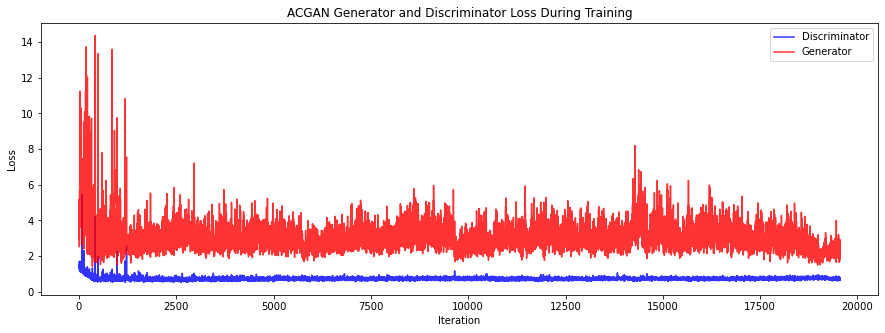

In [8]:
# plotting losses
plt.figure(figsize=(15, 5))
plt.title("ACGAN Generator and Discriminator Loss During Training")
plt.plot(d_losses, label='Discriminator', alpha=0.8, color='blue')
plt.plot(g_losses, label='Generator', alpha=0.8, color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
# initialization
generator = Generator(noise_dim, num_classes, img_channels).to(device)
discriminator = Discriminator(img_channels, num_classes).to(device)

# load the saved models
generator.load_state_dict(torch.load('ACGAN_generator.pth'))
discriminator.load_state_dict(torch.load('ACGAN_discriminator.pth'))

# set to eval, to avoid any issues
generator.eval()
discriminator.eval()

# creating a random noise amount for testing
test_size = 25
test_noise = torch.randn(test_size, noise_dim, 1, 1, device=device)
test_labels = torch.randint(0, num_classes, (test_size,), device=device).long()


# generate images
with torch.no_grad():
    generated_images = generator(test_noise, test_labels)

#save the images
save_image(generated_images, "test_generated_images.png", nrow=5, normalize=True)

In [27]:
with torch.no_grad():
    real_pred, _ = discriminator(real_imgs)
    fake_pred, _ = discriminator(generated_images)
    
    real_correct = (real_pred > 0.5).float()
    fake_correct = (fake_pred < 0.5).float()
    
    real_accuracy = real_correct.mean().item()
    fake_accuracy = fake_correct.mean().item()
    total_accuracy = (real_accuracy + fake_accuracy) / 2
    
    print(f"Discriminator accuracy on real images: {real_accuracy:.4f}, fake images: {fake_accuracy:.4f}, total: {total_accuracy:.4f}")

Discriminator accuracy on real images: 0.8500, fake images: 1.0000, total: 0.9250


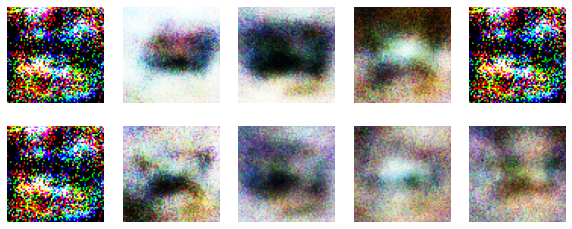

In [32]:
def generate_images(generator, noise_dim, num_classes, num_images=10):
    generator.eval()
    noise = torch.randn(num_images, noise_dim, 1, 1).cuda()
    random_labels = torch.randint(0, num_classes, (num_images,)).cuda()
    
    with torch.no_grad():
        generated_images = generator(noise, random_labels)
        
    generated_images = generated_images.cpu().detach()
    return generated_images

def show_generated_images(generated_images, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for ax, img in zip(axes.flatten(), generated_images):
        ax.axis('off')
        img = torchvision.utils.make_grid(img, normalize=True)
        ax.imshow(img.permute(1, 2, 0))
    plt.savefig('ACGAN_generated_photos.png')
    plt.show()

generated_images = generate_images(generator, noise_dim=100, num_classes=10, num_images=10)
show_generated_images(generated_images)